# Developing a model for actuator line turbulence injection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pxl.styleplot import set_sns
set_sns()
import os
from scipy.interpolate import interp1d
import scipy.stats

C:\Users\Pete\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
dataset_name = "NACA0021_2.0e+05.csv"
dataset_url = "https://raw.githubusercontent.com/petebachant/NACAFoil-OpenFOAM/master/processed/NACA0021_2.0e%2B05.csv"
local_fpath = "data/" + dataset_name


def download():
    """Download data and save locally"""
    df = pd.read_csv(dataset_url)
    df.to_csv(local_fpath, index=False)
    

if not os.path.isdir("data"):
    os.mkdir("data")

if not os.path.isfile(local_fpath):
    download()
    

def lookup(df, alpha_deg, quantity="cl"):
    """Lookup specified quantity at given angle of attack using linear interpolation."""
    alpha_deg = np.asarray(alpha_deg)
    f = interp1d(df.alpha_deg, df[quantity])
    return float(f(alpha_deg))


def find_alpha_ss(df, threshold=0.02):
    """Find static stall angle in degrees. Threshold is the change in $C_d$ per degree of angle of attack
    where static stall occurs.
    """
    d_cd_d_alpha = np.diff(df.cd)/np.diff(df.alpha_deg)
    n = np.where(d_cd_d_alpha > threshold)[0]
    alpha_ss = df.alpha_deg.iloc[n]
    alpha_ss = alpha_ss.iloc[0]
    return alpha_ss

Static stall angle: 15.0


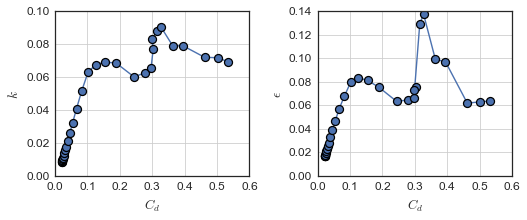

In [3]:
def load():
    return pd.read_csv(local_fpath)

labels = {"cd": "$C_d$",
          "alpha_deg": r"$\alpha$ (deg.)",
          "k": "$k$",
          "epsilon": r"$\epsilon$"}

x = "cd"

marker = "o"
df = load()
print("Static stall angle:", find_alpha_ss(df))
fig, ax = plt.subplots(ncols=2, figsize=(7.5, 3.25))
ax[0].plot(df[x], df.k, marker=marker)
ax[1].plot(df[x], df.epsilon, marker=marker)
ax[0].set_ylabel("$k$")
ax[1].set_ylabel("$\epsilon$")
for a in ax:
    a.set_xlabel(labels[x])
fig.tight_layout()
plt.show()

From these plots, it looks like a reasonable model would be a piecewise linear regression. Lower values of $C_d$ will match better, of course.

slope_k_low: 0.693707236018
slope_k_high: 0.0163893798862
slope_epsilon_low: 0.822433898014
slope_epsilon_high: -0.0232868598094
intercept_k_low: -0.00606355761476
intercept_k_high: 0.0684083504156
intercept_epsilon_low: -0.000310398654097
intercept_epsilon_high: 0.0897119060474
r_value_k_low: 0.999299098706
r_value_k_high: 0.217016923367
r_value_epsilon_low: 0.99639418034
r_value_epsilon_high: -0.115554170165


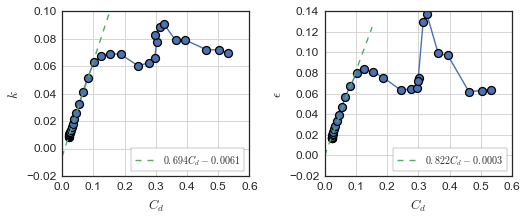

In [4]:
# Use scipy.stats

def fit(df, quantity="k", threshold=0.02):
    """Calculate linear fits for a quantity"""
    cd_thresh = lookup(df, find_alpha_ss(df, threshold=threshold), quantity="cd")
    data = {"cd_thresh": cd_thresh}
    for highlow in ["low", "high"]:
        if highlow == "low":
            dfi = df[df.cd <= cd_thresh]
        elif highlow == "high":
            dfi = df[df.cd > cd_thresh]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfi.cd, dfi[quantity])
        data["slope_" + quantity + "_" + highlow] = slope
        data["intercept_" + quantity + "_" + highlow] = intercept
        data["std_err_" + quantity + "_" + highlow] = std_err
        data["r_value_" + quantity + "_" + highlow] = r_value
        data["cd_fit_" + highlow] = np.linspace(0, dfi.cd.max() + 0.05, num=100)
        data[quantity + "_fit_" + highlow] = data["cd_fit_" + highlow]*slope + intercept
        if intercept < 0:
            sign = "-"
        else:
            sign = "+"
        data[quantity + "_" + highlow + "_eq"] = r"${:.3f}C_d {} {:.4f}$".format(slope, sign, np.abs(intercept))
    return data


def fit_all(df):
    data = {}
    for q in ["k", "epsilon"]:
        data.update(fit(df, q))
    return data


fits = fit_all(df)
for i in ["slope", "intercept", "r_value"]:
    for j in ["k", "epsilon"]:
        for k in ["low", "high"]:
            key = "_".join([i, j, k])
            print(key + ":", fits[key])
            
"""
For 0012

slope_k_low: 0.593388327002
slope_k_high: 0.0143189026664
slope_epsilon_low: 0.764339209867
slope_epsilon_high: 0.0136409303959
intercept_k_low: -0.00473891507231
intercept_k_high: 0.0775546672942
intercept_epsilon_low: -0.00151541577433
intercept_epsilon_high: 0.0966371905465
"""

fig, ax = plt.subplots(ncols=2, figsize=(7.5, 3.25))


for a, q in zip(ax, ["k", "epsilon"]):
    a.plot(df.cd, df[q], marker=marker, label="")
    a.plot(fits["cd_fit_low"], fits[q + "_fit_low"], linestyle="--", label=fits[q + "_low_eq"])
    # a.plot(fits["cd_fit_high"], fits[q + "_fit_high"], linestyle="--", label=fits[q + "_high_eq"])
    # plt.vlines(lookup(df, find_alpha_ss(df, threshold=0.03), quantity="cd"), -0.02, 0.1)
    a.set_xlabel(labels["cd"])
    a.set_ylabel(labels[q])
    a.legend(loc="lower right")

fig.tight_layout()
plt.show()

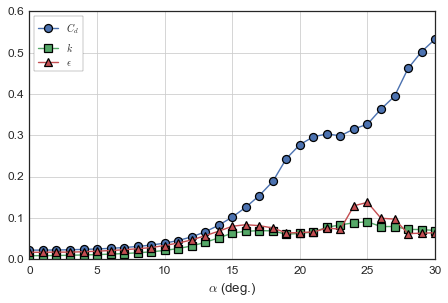

In [5]:
plt.plot(df.alpha_deg, df.cd, marker="o", label=labels["cd"])
plt.plot(df.alpha_deg, df.k, marker="s", label=labels["k"])
plt.plot(df.alpha_deg, df.epsilon, marker="^", label=labels["epsilon"])
plt.legend(loc="upper left")
plt.xlabel(labels["alpha_deg"])
plt.tight_layout()
plt.show()

It looks like the turbulence quantities basically "saturate" once we hit static stall, so we can try fitting a line with zero slope (taking the average value since they're evenly spaced?)

In [6]:
print("k saturation point:", df.k[df.alpha_deg > find_alpha_ss(df, threshold=0.02)].mean())
print("epsilon saturation point:", df.epsilon[df.alpha_deg > find_alpha_ss(df, threshold=0.02)].mean())

k saturation point: 0.0736347666667
epsilon saturation point: 0.0822859495201
